In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Pre-process Data

In [19]:
import numpy as np
from skimage.util.shape import view_as_windows
from PIL import Image
from matplotlib import pyplot as plt


def preprocess_data():
  train = []
  traing = []
  for i in range(1,401):
    imgName=''
    if i<100:
      if i<10:
        imgName='00'+str(i)
      else:
        imgName='0'+str(i)
    else:
      imgName=str(i)
    file = "/content/drive/MyDrive/SMAI/Project/train400/test_"+imgName+".png"
    image = Image.open(file)
    image = np.asarray(image)  
    train.append(image)

  train =  np.array(train).reshape((-1,180,180))

  mean = 0
  sigma = 25

  gauss = np.random.normal(mean,sigma,(180,180))

  traing = train + gauss

  train = train/255.0
  traing = traing/255.0

  for i in range(4):
    plt.imshow(train[i*100],cmap='gray')
    plt.show()
    plt.imshow(traing[i*100],cmap='gray')
    plt.show()
  
  return train,traing

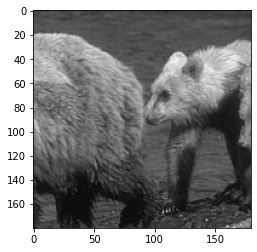

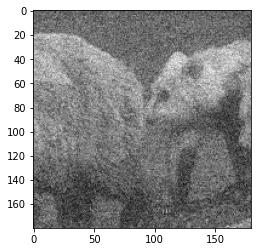

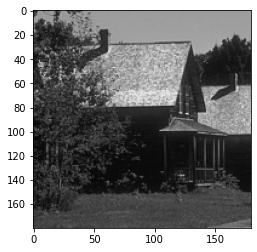

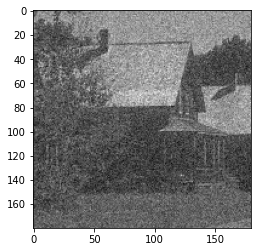

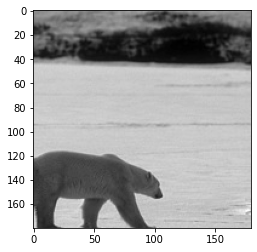

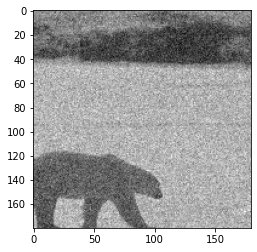

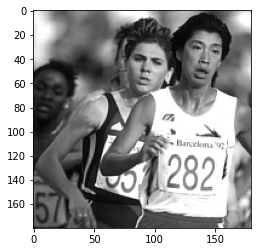

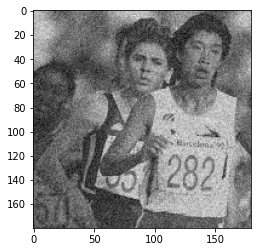

(300, 180, 180, 1) (300, 180, 180, 1) (100, 180, 180, 1) (100, 180, 180, 1)


In [31]:
from sklearn.model_selection import train_test_split

data, datag = preprocess_data()

data = np.expand_dims(data,axis=-1)
datag = np.expand_dims(datag,axis=-1)

traing, testg, train, test =  train_test_split(datag, data, test_size=0.25, shuffle=True)

print(train.shape,traing.shape, test.shape, testg.shape)

Define Model

In [21]:
import tensorflow as tf

In [22]:
class FeatureExtraction(tf.keras.Model):
  def __init__(self):
    super(FeatureExtraction,self).__init__()
    self.conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu")

    self.conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu")
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu")

  def call(self,input_tensor):
    x=self.conv_block_up(input_tensor)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(input_tensor)
    a=self.conv_block_down(z)

    return tf.keras.layers.Add()([x,y,z,a])

In [23]:
class FeatureIntegration(tf.keras.Model):
  def __init__(self):
    super(FeatureIntegration,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="relu")
    self.conv_block_up=tf.keras.layers.Conv2D(8,(3,3), strides=1,padding="same", activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3),dilation_rate=2,padding="same",activation="relu")
    self.conv_block_down=tf.keras.layers.Conv2D(8,(3,3), strides=1,padding="same", activation="relu")
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(8,(3,3),dilation_rate=2,padding="same",activation="relu")
    self.conv_block_second=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="relu")
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    x=self.conv_block_up(b)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(b)
    a=self.conv_block_down(z)
    add_first=tf.keras.layers.Add()([x,y,z,a])
    f=self.conv_block_second(add_first)
    return tf.keras.layers.Add()([f,input_tensor])

In [24]:
class Reconstruction(tf.keras.Model):
  def __init__(self):
    super(Reconstruction,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="sigmoid")
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    return b

Build Model

In [32]:
from keras.models import Sequential

model = Sequential()

model.add(FeatureExtraction())

model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())

model.add(Reconstruction())

model.compile(loss='mse')


results = model.fit(traing, train, epochs=50, verbose=1)

model.summary()


Epoch 1/50
10/10 [==============================] - 19s 919ms/step - loss: 0.0573
Epoch 2/50
10/10 [==============================] - 9s 867ms/step - loss: 0.0467
Epoch 3/50
10/10 [==============================] - 9s 862ms/step - loss: 0.0389
Epoch 4/50
10/10 [==============================] - 9s 861ms/step - loss: 0.0303
Epoch 5/50
10/10 [==============================] - 9s 859ms/step - loss: 0.0198
Epoch 6/50
10/10 [==============================] - 9s 858ms/step - loss: 0.0116
Epoch 7/50
10/10 [==============================] - 9s 858ms/step - loss: 0.0084
Epoch 8/50
10/10 [==============================] - 9s 857ms/step - loss: 0.0072
Epoch 9/50
10/10 [==============================] - 9s 858ms/step - loss: 0.0067
Epoch 10/50
10/10 [==============================] - 9s 858ms/step - loss: 0.0061
Epoch 11/50
10/10 [==============================] - 9s 858ms/step - loss: 0.0059
Epoch 12/50
10/10 [==============================] - 9s 858ms/step - loss: 0.0057
Epoch 13/50
10/10 [=====

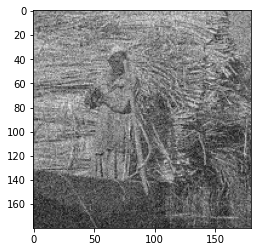

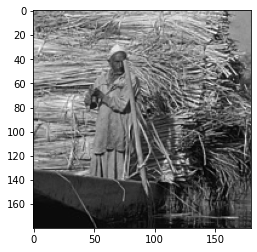

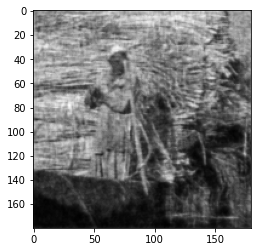

In [33]:
plt.imshow(np.squeeze(testg[20],(-1)),cmap='gray')
plt.show()

plt.imshow(np.squeeze(test[20],(-1)),cmap='gray')
plt.show()

temp = np.expand_dims(testg[20],axis=0)

pred = model(temp)

pred = np.squeeze(pred,(0,-1))

plt.imshow(pred*256,cmap='gray')
plt.show()